In [1]:
import sys
import math
import itertools
from pathlib import Path
from datetime import datetime

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

# 1. Add parent directory to path
sys.path.append(str(Path("..").resolve()))

from data_handling import (
    load_measurements_npz,
    load_state_npz,
    MeasurementDataset,
    MeasurementLoader
)

# 2. Import NEW modularized code (hyper_rbm)
from hyper_rbm import (
    SymmetricHyperRBM,
    train_loop,
    get_sigmoid_curve,
    save_model,
    generate_basis_states,
    calculate_exact_overlap
)

# Define paths
data_dir = Path("measurements")
state_dir = Path("state_vectors")
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

# Set global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")
print(f"Data resides in: {data_dir.resolve()}")

Running on: cpu
Data resides in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/parametric_qst/tfim_16_mod/measurements


In [2]:
def load_gt_wavefunction(path: Path, device: torch.device):
    """Loads the ground truth wavefunction from NPZ and converts to Tensor."""
    if not path.exists():
        return None
    psi_np, _ = load_state_npz(path)
    # Convert to tensor (Real part for TFIM)
    psi_true = torch.from_numpy(psi_np).real.float().to(device)
    return psi_true

print("Helper functions defined. (Basis generation and overlap calculation are now imported from hyper_rbm)")

Helper functions defined. (Basis generation and overlap calculation are now imported from hyper_rbm)


In [3]:
# --- EXPERIMENT CONFIG ---
SYSTEM_SIZE = 16
TRAIN_SAMPLES = 20_000
FILE_SUFFIX = "20000"

# Exact values from your 1D Chain Data
h_support = [0.50, 0.80, 0.95, 1.00, 1.05, 1.20, 1.50]
h_novel   = [0.60, 0.70, 1.30, 1.40]

seed = 42
torch.manual_seed(seed)
rng = torch.Generator().manual_seed(seed)

# Construct paths (1D Chain)
file_paths = []
print("Loading Training Data (1D Chain L=16)...")
for h in h_support:
    fname = f"tfim_{SYSTEM_SIZE}_h{h:.2f}_{FILE_SUFFIX}.npz"
    fpath = data_dir / fname
    if fpath.exists():
        file_paths.append(fpath)
    else:
        print(f"  ! MISSING: {fname}")

ds = MeasurementDataset(file_paths, load_measurements_npz, ["h"], [TRAIN_SAMPLES] * len(file_paths))
loader = MeasurementLoader(ds, batch_size=1024, shuffle=True, drop_last=False, rng=rng)
print(f"Dataset loaded. Shape: {ds.values.shape}")

Loading Training Data (1D Chain L=16)...
Dataset loaded. Shape: torch.Size([140000, 16])


In [4]:
# --- Hyperparameters ---
HIDDEN_UNITS = 64
COND_WIDTH = 64
CD_K = 20
LR_INIT = 1e-2
LR_FINAL = 1e-4
N_EPOCHS = 50
NOISE_FRAC = 0.1

# Initialize Model (SymmetricHyperRBM)
model = SymmetricHyperRBM(
    num_v=SYSTEM_SIZE,
    num_h=HIDDEN_UNITS,
    hyper_dim=COND_WIDTH, # Replaces conditioner_width
    k=CD_K
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR_INIT)
schedule_steps = N_EPOCHS * len(loader)
scheduler = get_sigmoid_curve(LR_INIT, LR_FINAL, schedule_steps, falloff=0.002)

print(f"Training Symmetric Hyper RBM on L={SYSTEM_SIZE}...")
model = train_loop(
    model=model,
    optimizer=optimizer,
    loader=loader,
    num_epochs=N_EPOCHS,
    lr_schedule_fn=scheduler,
    noise_frac=NOISE_FRAC,
    rng=rng
)
print("Training Complete.")

Training Symmetric Hyper RBM on L=16...
Epoch  | Loss       | LR        
-----------------------------------
1      | +0.0205     | 0.009986
10     | -0.0056     | 0.009840
20     | +0.0135     | 0.007997
30     | -0.0059     | 0.002109
40     | -0.0067     | 0.000260
50     | -0.0118     | 0.000110
Training Complete.


Generating full Hilbert space for exact evaluation...
h      | Type       | Overlap   
-----------------------------------
0.50   | Support    | 0.99960
0.60   | Novel      | 0.99932
0.70   | Novel      | 0.99901
0.80   | Support    | 0.99877
0.95   | Support    | 0.99826
1.00   | Support    | 0.99793
1.05   | Support    | 0.99793
1.20   | Support    | 0.99872
1.30   | Novel      | 0.99836
1.40   | Novel      | 0.99848
1.50   | Support    | 0.99861


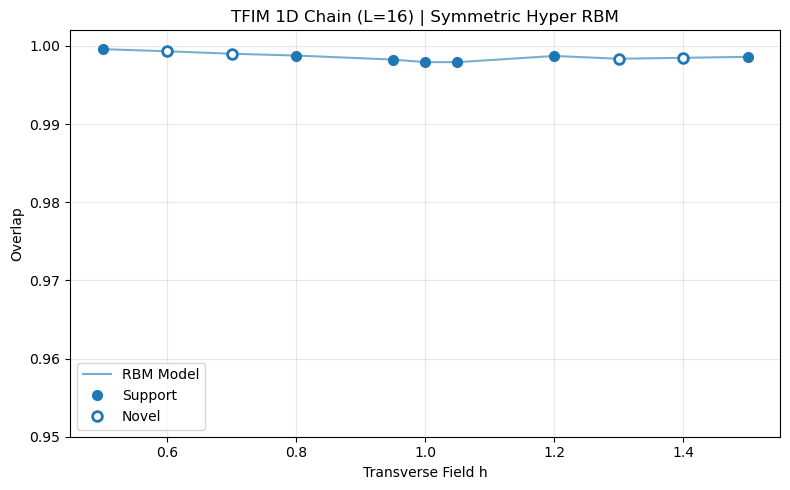

In [5]:
print("Generating full Hilbert space for exact evaluation...")
# Use imported metric function
all_states = generate_basis_states(SYSTEM_SIZE, device)
all_eval_h = sorted(list(set(h_support + h_novel)))

results = []
print(f"{'h':<6} | {'Type':<10} | {'Overlap':<10}")
print("-" * 35)

for h_val in all_eval_h:
    gt_fname = f"tfim_{SYSTEM_SIZE}_h{h_val:.2f}.npz"
    gt_path = state_dir / gt_fname

    # Load Ground Truth Tensor
    psi_true = load_gt_wavefunction(gt_path, device)

    if psi_true is None:
        continue

    # Use imported metric function
    # Note: calculate_exact_overlap handles normalization of psi_true internally
    overlap = calculate_exact_overlap(model, h_val, psi_true, all_states)

    is_supp = any(np.isclose(h_val, s, atol=1e-5) for s in h_support)
    pt_type = "Support" if is_supp else "Novel"

    results.append({"h": h_val, "overlap": overlap, "type": pt_type})
    print(f"{h_val:<6.2f} | {pt_type:<10} | {overlap:.5f}")

df_res = pd.DataFrame(results)

# Plot
plt.figure(figsize=(8, 5), dpi=100)
supp = df_res[df_res["type"] == "Support"]
nov  = df_res[df_res["type"] == "Novel"]
plt.plot(df_res["h"], df_res["overlap"], '-', color='tab:blue', alpha=0.6, label="RBM Model")
plt.plot(supp["h"], supp["overlap"], 'o', color='tab:blue', markersize=7, label="Support")
plt.plot(nov["h"], nov["overlap"], 'o', color='tab:blue', markerfacecolor='white', markeredgewidth=2, markersize=7, label="Novel")
plt.xlabel("Transverse Field h")
plt.ylabel("Overlap")
plt.title(f"TFIM 1D Chain (L={SYSTEM_SIZE}) | Symmetric Hyper RBM")
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"hyper_rbm_tfim_16_{TRAIN_SAMPLES}_{timestamp}.pt"
save_path = models_dir / filename

config = {
    "train_samples": TRAIN_SAMPLES,
    "epochs": N_EPOCHS,
    "h_support": h_support,
    "h_novel": h_novel,
    "lr_init": LR_INIT
}

# New save_model signature: (model, config, results, path)
# Optimizer state is not saved in this streamlined version
save_model(model, config, results, save_path)

Model saved to: models/hyper_rbm_tfim_16_20000_20260114_210249.pt
